# Introduction

As the internet gained popularity and more and more web sites and web pages are created, the importance of efficient internet search engines to find relevant information also became apparent.  Several search engines were developed but Google's PageRank algorithm had the greatest impact because it gave fast results and was the first to defeat spammers. In this presentation, we will take a look at Google's PageRank algorithm and its efficient computation, as well as the tactics employed by spammers to direct search results to their target pages, and the methods to counter them. 

We will make use of a python module called $linkan$ to illustrate the ideas presented in this section. Let us import that module together with other basic python modules before proceeding.

In [101]:
import numpy as np
import linkan  

# PageRank

## History 

### Early Search Engines

Early approaches to search engines involved crawling web pages and then listing terms that appeared and storing them in an *inverted index*, a data structure that allows locating all places *pointed to* by a term. 

When a *search query* is given:
* terms are extracted from the search query
* pages are pointed to by the terms are retrieved
* pages are ranked according to
    * how the terms were used in the page (e.g. terms appearing in headers have more importance)
    * how frequent those terms appeared in the page

### Term Spam

Some unethical people saw the opportunity of fooling search engines to direct users to their site (a sort of free advertisement).  For example, if they want to direct users searching for 'movie' to their site, they would do the following:
* Add a *lot* of occurances of the term 'movie' to their site (with font color similar to page's background to hide the text)
* Do a search for *movie* and copy contents of the highest-ranked page (again, using the "invisible text" approach above).
This technique for fooling a search engine into believing that a page is something that it is not is called *term spam*.

## Introducing Page Rank

To combat term spam, Google introduced two innovations
* They introduced PageRank to assess the importance of pages
    - A simulation of Web surfers, starting at a random page, randomly following outlinks in each page they visit. Process iterates many times. 
    - The pages visited more often by the surfers are considered more important
* Pages were judged not only by the terms that appeared in them, but by the *terms used in the link* (the anchor text), and the terms near the links to that page.

## Graph Notations

To illustrate how PageRank and other Link Analysis algorithms work, it is useful to think of the Web as a directed graph with the following characteristics:
* **nodes** represent pages
* **arcs** represent links from one page to another 

### Defining and Displaying Graphs with NetworkX

A useful package for defining and displaying graphs in python is NetworkX. Below is an illustration of how we create a directed graph by defining the graph's nodes and edges. We then show the graph with a call to the `draw` command.

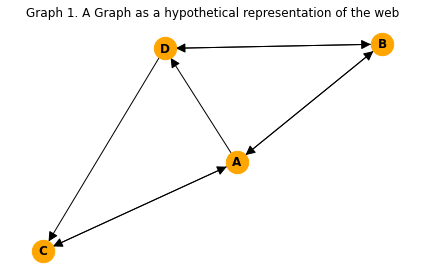

In [102]:
import networkx as nx
import matplotlib.pyplot as plt

G1 = nx.DiGraph()
G1.add_nodes_from(["A","B","C","D"])
G1.add_edges_from([
    ("A","B"), ("A","C"), ("A","D"), 
    ("B","A"), ("B","D"),
    ("C","A"),    
    ("D","B"), ("D","C")
])

plt.figure()  
plt.title("Graph 1. A Graph as a hypothetical representation of the web")
nx.draw(G1, node_size=500, node_color='orange', with_labels=True, font_weight='bold', arrowsize=20)
plt.tight_layout()
plt.show()

### Adjacency Matrix

The **Adjacency Matrix** is a representation showing which vertices are adjacent, i.e., connected by edges or links. Formally, if $A$ is the adjacency matrix of a graph $G$, and $a_{ij}$ are the elements of $A$, 
$a_{ij}=1$ if there is a link from node $i$ to node $j$, otherwise, $a_{ij}=0$.

In the discussion later on Hubs and Authorities, this matrix will also be known as the **Link Matrix**. It represents the existence of outgoing links from one page to another.

In NetworkX, the adjacency matrix can be computed using the `adjacency_matrix` function. This produces a sparse matrix. We can convert this to a dense matrix by calling the `toarray` method.

In [103]:
A = nx.adjacency_matrix(G1).toarray()
A

array([[0, 1, 1, 1],
       [1, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 1, 0]])

### Transition Matrix

In the computation of PageRank, an important data structure is the **Transition Matrix**.

Recall the idea of a surfer randomly browsing through the Web. Given graph $G1$, our hypothetical representation of the Web in Figure 1, if the surfer is at page A, the following are the probabilities of the next page he will visit:
* page A: 0
* page B: 1/3
* page C: 1/3
* page D: 1/3

We can do the same for all other nodes and define a *Transition Matrix* to represent the the probabilities of where this surfer would go next, for any starting location in the Web. 

To generate the Transition Matrix from a graph, we will need the *transpose* of its Adjacency Matrix as well as a vector of its out degrees (the number of links coming out from a node or page) . We have already computed for $G1$'s adjacency matrix and stored it in $A$; to get the outlinks of the nodes, we can use the graph's `out_degree` method: 

In [104]:
G1.out_degree

OutDegreeView({'A': 3, 'B': 2, 'C': 1, 'D': 2})

We then convert this into an numpy array, getting only the values of the outdegrees:

In [105]:
d = np.array([x[1] for x in list(G1.out_degree)])
d

array([3, 2, 1, 2])

Now we can compute the Transition matrix:

In [106]:
M = A.T * (1/d)
M

array([[0.        , 0.5       , 1.        , 0.        ],
       [0.33333333, 0.        , 0.        , 0.5       ],
       [0.33333333, 0.        , 0.        , 0.5       ],
       [0.33333333, 0.5       , 0.        , 0.        ]])

In [107]:
def transition_matrix_beta(G):
    """
    Compute the Transition Matrix given a NetworkX graph
    This version cannot handle dead-ends, i.e., nodes without outlinks,
    hence it's called beta
    
    Parameters
    ----------
    G : NetworkX graph
        Graph to extract the transition matrix
    Returns
    -------
    M : numpy array
        Numpy array of the transition matrix of G
    """        
    A = nx.adjacency_matrix(G).toarray()
    d = np.array([x[1] for x in list(G.out_degree)])
    M = A.T * (1/d)
    return M

The transition matrix could now be computed from a NetworkX graph as follows:

In [108]:
transition_matrix_beta(G1)

array([[0.        , 0.5       , 1.        , 0.        ],
       [0.33333333, 0.        , 0.        , 0.5       ],
       [0.33333333, 0.        , 0.        , 0.5       ],
       [0.33333333, 0.5       , 0.        , 0.        ]])

This matrix $M$ represents the transition matrix of $G1$, with the indices for nodes A, B, C, D being 0,1,2,3, respectively.

## PageRank Computation

PageRank is a function that assigns a real number to a page in the Web, reflecting the page's importance. There are variations in the algorithms that compute the PageRank. We will tackle a few of them in the succeeding sections. 

Formally, if $m_{ij}$ are the elements of $M$, and node $j$ has $d$ outgoing links, we set $m_{ij}$ to $1/d$ if there is a link from page $j$ to page $i$, otherwise, we set it to 0. From this, we get that the $j$th column represents the transition probability distribution for a surfer who is at node $j$. This matrix is the **idealized PageRank**. Note that the sum of each column is exactly 1. Such a matrix where each column sums up to one is said to be *stochastic*.

To compute the actual PageRank, we have to iterate the surfing process.
* Surfer starts at any location in the web with equal probability. Let's represent this as $\textbf{v}^{(0)}$.
* After one step, the distribution of the surfer will be $\textbf{v}^{(1)}$ = $M \textbf{v}^{(0)}$
* After two steps, the distribution of the surfer will be $\textbf{v}^{(2)}$ = $M\textbf{v}^{(1)}$ =  $M(M \textbf{v}^{(0)})$ = $M^{2}  \textbf{v}^{(0)}  $  

Figure 2 below illustrates how $\textbf{v}$ is updated for one iteration, showing that the updated value of $\textbf{v}$ gives the new probability distribution  for all the nodes.

<img src='images/PageRankUpdate.PNG' style="width: 450px"></img>
<center><b>Figure 2. One iteration/update of PageRank Algorithm</b></center>

We can thus formulate an update rule $\textbf{v}^{(i+1)} = M\textbf{v}^{(i)}$, which is an example of a *Markov process*.  It is known that such a process will stabilize at $\textbf{v} = M\textbf{v}$ if the following conditions are met:
1. The graph is strongly connected
2. There are no dead ends

From the above, we observe that stability can be reached if $M\textbf{v}$ no longer updates $\textbf{v}$. 

This $\textbf{v}$ is, in fact, the an *eigenvector* of $M$. Recall:
An *eigenvector* of a matrix $M$ is a vector $\textbf{v}$ that satisfies
$$ \textbf{v}= \lambda M \textbf{v} $$
where $\lambda$ is some constant known as the *eigenvalue*.

Since $M$ is stochastic, we can further say that $\textbf{v}$ is the principal eigenvector of $M$ and $\lambda =1$.

From this, we can say that the principal eigenvector of $M$  gives us the probability distribution of where (at which page) a random surfer would most likely be after a long time. Thus,the principal eigenvector actually gives us the PageRank of each page. 

## Iterative Method for Computing PageRank

Here, we summarize the process of computing the PageRank known as the *Power Iteration Method*. Given $n$ pages/nodes:
1. Create the characteristic matrix $M$  (size $nxn$), whose elements $m_{ij}$ are defined as follows:
 
    $
        m_{ij}=\left\{
        \begin{array}{@{}ll@{}}
        1/d, & \text{if there is a link from page } j \text{ to } i \text{ and page } j \text{ has } d \text{ outlinks}\\
        0, & \text{otherwise}
        \end{array}\right.
    $


2. Initialize $\textbf{v}^{(0)}$ 

    $
        \textbf{v}^{(0)}_{i} = 1/n \text{, for all } i 
    $


3. Iteratively update $\textbf{v}$ 

    $
    \textbf{v}^{(t+1)} = M\textbf{v}^{(t)}
    $


4. Stop when $\lvert \textbf{v}^{(t+1)}-\textbf{v}^{(t)} \rvert < \epsilon $.

### Power Iteration Method for Computing the Idealized PageRank

To get a concrete idea how the algorithm works, below is a python implementation of the Idealized PageRank using the Power Iteration Method.

In [31]:
def idealized_page_rank(M, tol=10**-6, max_iter=100):
    """
    Compute the Idealized PageRank (without Taxation) of a given Transition Matrix    
    
    Parameters
    ----------
    M : numpy array
        Transition Matrix: Array of shape (n, n), where n is the number of nodes in the network
    tol : float
        Tolerance: Iteration stops if the distance between previous and updated PageRank vectors 
        goes below this value
    max_iter : integer
        Maximum number of iterations
    Returns
    -------
    v : numpy array
        Vector of size n containing the ordinary PageRank values 
    """    
    n = M.shape[0]
    v = np.ones(n)/n
    delta = 1/tol  # initialize vector difference to a large number
    i = 0
    while delta > tol:
        i += 1
        prev_v = v
        v = M.dot(v)
        delta = np.sum(np.abs(v-prev_v)) # compute L1 norm
        if i >= max_iter:
            break
    return v

Applying function to the $G1$ in Figure 1, we get the following results.

In [109]:
M = transition_matrix(G1)
idealized_page_rank(M)

array([0.33333349, 0.22222217, 0.22222217, 0.22222217])

## Issues with PageRank

In this subsection, we consider two issues that affect the computation of PageRank.

### Deadends

First, let's take a look at *deadends*, pages with no outgoing links. The graph $G2$ below is the same as $G1$ except that the outgoing link from node C was removed.

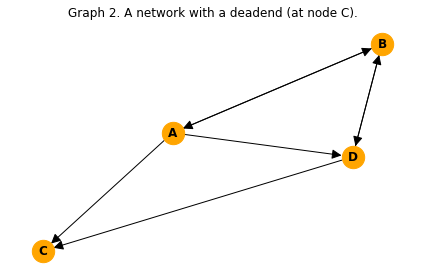

In [110]:
G2 = nx.DiGraph()
G2.add_nodes_from(["A","B","C","D"])
# No outgoing link from node C
G2.add_edges_from([
    ("A","B"), ("A","C"), ("A","D"), 
    ("B","A"), ("B","D"),
    ("D","B"), ("D","C")
])

plt.figure()  
plt.title("Graph 2. A network with a deadend (at node C).")
nx.draw(G2, node_size=500, node_color='orange', with_labels=True, font_weight='bold', arrowsize=20)
plt.tight_layout()
plt.show()

Consider the graph bove.  Here we see that node C does not have any outgoing links, thus C is a deadend. The problem with deadends is that it is like a sink for infornation because while it 'absorbs' PageRank scores during the iterations: it does not pass them on to other nodes. As a result, some or all the components would eventually go to zero.

To see this effect, let us edit our `transition_matrix` function to handle nodes with zero degrees. The main problem is that a division by zero error could occur when we divide $A.T$ by $d$ if  $d$ has zero values. To address this, we just set the zero values of $d$ to 1. This will not affect the resulting matrix since the corresponding column in $A.T$ will all be zeros (recall that there are no outlinks for this node.)

In [28]:
def transition_matrix(G):
    """
    Compute the Transition Matrix given a NetworkX graph
    
    Parameters
    ----------
    G : NetworkX graph
        Graph to extract the transition matrix
    Returns
    -------
    M : numpy array
        Numpy array of the transition matrix of G
    """        
    A = nx.adjacency_matrix(G).toarray()
    d = np.array([x[1] for x in list(G.out_degree)])
    
    # get indices with zero and replace them with 1 to avoid division by zero
    # this won't affect the result since the corresponding column will have all zeros
    d[d==0]=1
    
    M = A.T * (1/d)    
    return M

Let's now compute the transition matrix for Graph 2 and see what happens when we apply the Power Iteration Method.

In [14]:
M2 = transition_matrix(G2)
M2

array([[0.        , 0.5       , 0.        , 0.        ],
       [0.33333333, 0.        , 0.        , 0.5       ],
       [0.33333333, 0.        , 0.        , 0.5       ],
       [0.33333333, 0.5       , 0.        , 0.        ]])

First, we observe that the characteristic Matrix is no longer *stochastic* - the sum at column C is 0.

In [15]:
M2.sum(axis=0)

array([1., 1., 0., 1.])

In [16]:
r = idealized_page_rank(M2)

In [17]:
np.rint(r)

array([0., 0., 0., 0.])

We observe that the final values of all elements of $\textbf{v}$ are 0.

### Spider Traps

Another issue that PageRank algorithm has to face is the existence of spider traps. A spider trap is a set of nodes with no dead ends but no link out of the set of nodes comprising the spider trap. The effect on the PageRank algorithm is the opposite of deadends. Whereas in deadends information "leaks out" from the deadend, in the case of spider traps, they get accumulated.
Graph 3 below is an example of a network with a 1-node spider trap.

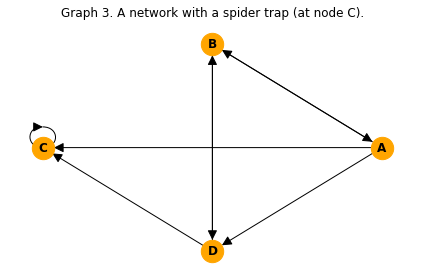

In [25]:
G3 = nx.DiGraph()
G3.add_nodes_from(["A","B","C","D"])
# self-link at node C
G3.add_edges_from([
    ("A","B"), ("A","C"), ("A","D"), 
    ("B","A"), ("B","D"),
    ("C","C"),
    ("D","B"), ("D","C")
])

plt.figure()  
plt.title("Graph 3. A network with a spider trap (at node C).")
pos = nx.circular_layout(G3)
nx.draw(G3, pos, node_size=500, node_color='orange', with_labels=True, font_weight='bold', arrowsize=20)
plt.tight_layout()
plt.show()

In [29]:
M3 = transition_matrix(G3)
M3

array([[0.        , 0.5       , 0.        , 0.        ],
       [0.33333333, 0.        , 0.        , 0.5       ],
       [0.33333333, 0.        , 1.        , 0.5       ],
       [0.33333333, 0.5       , 0.        , 0.        ]])

If we compute the PageRank, we'll notice that all the traffic goes to node C.

In [30]:
r = idealized_page_rank(M3)
np.rint(r)

array([0., 0., 1., 0.])

## PageRank with Taxation

A solution to the two issues we mentioned above (deadends and spider traps) is to allow each random surfer to *teleport* with a small probability $\beta$ rather than following an out-link in its current page. This method of random teleportation is called *taxation* in the textbook.

If $\textbf{e}$ is a vector of 1's of size $n$, The iteration step now becomes:

$
    \textbf{v}^{(t+1)}= \beta M\textbf{v}^{(t)} + (1-\beta)\textbf{e}/n
$



$\beta$ values are usually chosen in the range of 0.8 to 0.9. 

We create a taxed version of the PageRank below.

In [71]:
def taxed_page_rank(M, beta=0.8, tol=10**-6, max_iter=100):
    """Compute the Taxed PageRank (without Taxation) of a given Transition Matrix    
       Note that this not make use of `e` -- the vector of ones 
       since numpy's broadcasting takes care of properly computing a vector-constant addition
    Parameters
    ----------
    M : numpy array
        Transition Matrix: Array of shape (n, n), where n is the number of nodes in the network
    tol : float
        Tolerance: Iteration stops if the distance between previous and updated PageRank vectors 
        goes below this value
    max_iter : integer
        Maximum number of iterations
    Returns
    -------
    v : numpy array
        Vector of size n containing the ordinary PageRank values 
    """    
    n = M.shape[0]
    v = np.ones(n)  
    delta = 1/tol # initialize vector difference to a large number
    i = 0
    while delta > tol:
        i += 1
        prev_v = v
        v = beta*M.dot(v) + ((1-beta)/n)  
        delta = np.sum(np.abs(v-prev_v))  # compute L1 norm  
        if i >= max_iter:
            break
    return v

In [72]:
np.array([15/148, 19/148, 95/148, 19/148])

array([0.10135135, 0.12837838, 0.64189189, 0.12837838])

In [73]:
M3 = transition_matrix(G3)
taxed_page_rank(M3)

array([0.10135135, 0.12837838, 0.64189557, 0.12837838])

## Using PageRank in Search Engine

Google is said to use over 250 properties of pages from which the ranking is decided, among those properties, PageRank is among the important ones. Others are:
- presence of search terms
- where the search terms appear in the page (e.g. headers)
- search terms appearing in pages that link to the page in question

# Efficient Computation of PageRank

## Motivation

"In practice, for the Web itself, 50–75 iterations are sufficient to converge to within the error limits of double-precision arithmetic." - Leskovec et al.

In 2008, [Google said that it was indexing 1 trillion pages](https://googleblog.blogspot.com/2008/07/we-knew-web-was-big.html). and according to [this site](https://venturebeat.com/2013/03/01/how-google-searches-30-trillion-web-pages-100-billion-times-a-month/#:~:text=Google%20says%20that%20it%20stores,now%20at%20100%20million%20gigabytes.), the number of pages is now 30 trillion. Let's calculate the amount of memory needed to store the vector $\textbf{v}$ for the 2008 reported value of Google of 1 trillion pages.

In [ ]:
n = 1*(10**12)      # 1 trillion pages
bytes_per_float = 8      
bytes_per_gig = 10**9
n * bytes_per_float / bytes_per_gig

Thus, the vector $\textbf{v}$ is so large that it can't fit in memory; we can just imagine how large $M$ woul be. For this problem, performing MapReduce would definitely be beneficial. In fact, Google's original purpose for MapReduce is to calculate the matrix-vector multiplications needed in PageRank.

We present below two issues:

1. The matrix $M$, is, in fact, very sparse. We can save a lot of space by storing only the nonzero elements.
2. For some reason, we may opt to not use MapReduce, or, we wish to reduce the amount of data passed from Map tasks to Reduce tasks. 

Let's discuss the solutions to these two issues.

## Representing Transition Matrices

Let us consider Graph 1 again. 

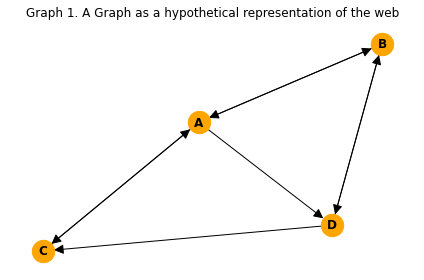

In [39]:
plt.figure()  
plt.title("Graph 1. A Graph as a hypothetical representation of the web")
nx.draw(G1, node_size=500, node_color='orange', with_labels=True, font_weight='bold', arrowsize=20)
plt.tight_layout()
plt.show()

We can save on space by only representing the nonzero entries in the Transition Matrix. 

|Source|(Destination, Value)|
|:--:|:--|
|A| (B, 1/3), (C, 1/3), (D, 1/3)|
|B| (A, 1/2), (D, 1/2)|
|C| (A, 1)|
|D| (B, 1/2), (C, 1/2)|

However, we can actually go even further, by only representing the number of out-degrees from a node, and noting the other nodes to which it links. This works since we know that the probability of transitioning from one node to a node it connects to is the same (which is $1/\text{out-degree}$). Working this way, allows us to use integers instead of floats for our representation of the Transition Matrix. 

|Source|Degree|Destination|
|:--:|:--:|:--|
|A|3|B, C, D|
|B|2|A, D|
|C|1|A|
|D|2|B, C|

## PageRank Implementation Using Map Reduce

### Applying Map Reduce when  *v* fits in memory

First, let's consider the naive case when $\textbf{v}$ fits in the memory.

Recall the update rule $\textbf{v}^{(t+1)}= \beta M\textbf{v}^{(t)} + (1-\beta)\textbf{e}/n$. 

For simpler notation, let us render this as 
$
\textbf{v'}= \beta M\textbf{v} + (1-\beta)\textbf{e}/n
$


Recall that $\beta$ is a constant and $\textbf{e}$ is just a vector of 1's. Thus, the update rule above is equivalent to 
- Performing a matrix-vector multiplication ($M\textbf{v}$)
- Multiplying the result by a constant ($\beta$)
- Adding to the result another constant ($(1-\beta)/n$)


Thus, the focus of the MapReduce functions will be on the matrix-vector multiplication, and it can be described as follows:

**Map function**: Produce key-value pair $(i, m_{ij}v_j)$ <br>
**Reduce function**: Sum all values associated with a given key $i$, resulting in the pair $(i, x_i)$

#### Pyspark Illustration

Please refer to [PageRank_Using_MapReduce](PageRank_Using_MapReduce.ipynb) notebook for a discussion on the implementation of this procedure in pyspark. 

###  Applying Map Reduce when *v* does not fit in memory: Striping Approach

As seen in the previous discussion, for Google's PageRank, $\textbf{v}$ does not actually fit in memory. A solution to address this is **striping**.
Here we divide the matrix $M$ into vertical stripes of equal length and similarly divide $\textbf{v}$ into horizontal stripes of equivalent height as shown in Figure 5 below. The goal is to choose a stripe length small enough so that $\textbf{v}$ could fit conveniently into the memory of one compute node.

<img src='images/StripingApproach.PNG' width='350px'></img>
<center><b>Figure . Division of matrix and vector into 5 stripes</b></center>

The MapReduce changes in the following way: Each Map task is assigned a chunk from one of the
stripes of the matrix and gets the entire corresponding stripe of the vector. The Map and Reduce functions act exactly as previously described.

### Applying Map Reduce when *v* does not fit in memory: 'Blocking' Approach

The striping method described above has the following issues:
1. A vertical stripe of $M$ multiplied by a horizontal stripe of $\textbf{v}$ actually produces a vector of the same size as $\textbf{v}$. A problem happens this vector does not actually fit in memory.
2. If we want to aggregate sums at the Map tasks before sending to the Reducer, the striping method will not be efficient since the product of the matrix and vector stripes affect all rows of the resulting vector $\textbf{v'}$

To circumvent this limitation is partition $M$ into $k x k$ blocks while the vector $\textbf{v}$ is partitioned into $k$ stripes as shownin Figure 6 below. 

<img src='images/BlockingApproach.PNG' width='450px'></img>
<center><b>Figure 6. Division of matrix and vector into 5 stripes</b></center>

The MapReduce can be implemented thus:
- There are $k^2$ Map tasks
- Each Map task gets one square, say $M_{ij}$, and one stripe of the vector, say $\textbf{v}_j$
- For each Map task, add the terms with common keys before sending to the Reducer 

#### Advantage of this approach
- As we process $M_{ij}$, we can keep both $\textbf{v'}_i$ and $\textbf{v}_j$ in memory 
    - Note that all terms generated from $M_{ij}$ and $\textbf{v'}_j$ contribute only to $\textbf{v'}_i$ and no other stripe of $\textbf{v}$

### Sparse Representation of the Blocks in the Transition Matrix

Blocks can also be represented as sparse matrix. We do not expound on it here for conciseness. See Leskovec et al., section 5.2.4.

# Topic-Sensitive PageRank

## Motivation

The PageRank algorithm could be modified so that it can put more weight to certain pages depending on some topic. One possible motivation for this is to make search results more relevant to the user. The *Topic-Sensitive PageRank* creates a vector for a set of topics with the goal of giving bias to these topics.  Obviously, the ideal case would be to create one vector per user, but this is simply not possible. Having vectors for only a number of topics, while more limited, can still provide more relevant search results.

Deciding on the topic set is the first step in implementing Topic-Sensitive PageRank.  One such possible set is the 15 top-level categories of the [Open Directory](https://dmoz-odp.org/): Arts, Business, Computers, etc.

## Implementation

The implementation of Topic-Sensitive PageRank is similar to the general PageRank, except that teleports only happen to a predefined *teleport set* consisting of pages from a specific topic. 

Given
- $S$ -  the indices of the pages belonging to the teleport set
- $|S|$ - the size of the teleport set
- $\textbf{e}_s$ - vector such that
  
    $
        {\large \textbf{e}_{s_{i}}}=\left\{
        \begin{array}{@{}ll@{}}
        1, & \text{if } i \text{ is in } S \\
        0, & \text{otherwise}
        \end{array}\right.
    $

Then, the *topic-sensitive PageRank* for $S$ is the limit of the following iteration:

   $$
        \textbf{v'}= \beta M\textbf{v} + (1-\beta)\textbf{e}_s/|S|
   $$

<div class="alert alert-info">
    
**Exercise 4:  Topic-Sensitive PageRank . [2 pts]**
    
Update the function in Exercise 3 to implement Topic-Sensitive PageRank. You may test your function with Nodes $B$ and $D$ belonging to the topic teleport set $S$.

</div>

In [77]:
def personalized_page_rank(M, S, beta=0.8, tol=10**-6, max_iter=100):
    """Compute the personalized or topic-sensitive PageRank (with taxation) 
    of a given Transition Matrix 

    Parameters
    ----------
    M : numpy array
        Transition Matrix: Array of shape (n, n), where n is the number of nodes in the network
    beta :  float
        probability of following an outlink
    S :  list
        indices of pages belonging to the teleport set (indices start at 0)
    tol : float
        Tolerance: Iteration stops if the distance between previous and updated PageRank vectors 
        goes below this value
    max_iter : integer
        Maximum number of iterations
    Returns
    -------
    v : numpy array
        Vector of size n containing the PageRank values 
    """
    
    n = M.shape[0]
    e = np.zeros(n)
    for i in S:
        e[i] = 1
        
    v = np.ones(n)
    delta = 1/tol # initialize to a large number
    i = 0
    while delta > tol:
        i += 1
        prev_v = v
        v = beta*M.dot(v) + ((1-beta)/len(S))*e
        delta = np.mean(np.abs(v-prev_v))
        if i >= max_iter:
            break        
    return v

To illustrate, assuming that pages B and D are our teleport set, we can implement personalized PageRank in Graph1 as follows

In [78]:
S = [1,3]
M = transition_matrix(G1)
personalized_page_rank(M,S)

array([0.25714753, 0.2809555 , 0.1809555 , 0.2809555 ])

##  Using Topic-Sensitive PageRank in a search engine
1. Choose a set of topics
2. Decide on a teleport set for each topic
3. Given a query, find the most relevant topic
4. Use the corresponding teleport set in calculating the topic-sensitive PageRank

# Combating Link Spam

When it became obvious that *term spam* was no longer working well with search algorithms such as PageRank, malevolent people found yet another way to fool the PageRank algorithm into wrongly assessing the importance of their pages according to their purposes. In this section, we will look at this new technique called *link spam* and how it can be countered.

## Link Spam

Figure 7 below shows how a *spam farm* operates to drive traffic to a target page. 

<img src='images/LinkSpam.PNG' width='550px'></img>
<center><b>Figure 7. Spam Farm architechture</b></center>
<center><small>Image source: Leskovec, Rajaraman, and Ullman. Mining of Massive Datasets, 2019.</small></center>

Examples of accessible pages are blogs, newspapers or other sites where people can leave comments like “I agree. "Please see my article at mySpamFarm.com."

#### PageRank increase contributed by Link Spam

Without going through the math, it can be shown that 

Given
* $n$ - total number of pages in the Web
* $x$ - PageRank contributed by accessible pages
* $m$ - own/supporting pages in the spam farm
* $y$ - the page rank of the target page

    $\large {  y = \frac{x}{1-\beta^2} + c \frac{m}{n}  }$

   where $c = \beta/(1+\beta) $

Let's compute the values of the two terms in the RHS assuming that  $\beta$=0.85.

In [80]:
beta = 0.85
term1 = 1-beta**2
term2 = beta/(1+beta)
term1, term2

(0.2775000000000001, 0.45945945945945943)

There are two possible ways of combating Link Spam: *TrustRank* and *Spam Mass*. We discuss these next.

## TrustRank

*TrustRank* is a variation of Topic-Sensitive PageRank where the 'topic' that defines the teleport set is a set of pages that are believed to be trustworthy. A feasible way of selecting the trustworthy pages is to pick a domain whose membership is controlled. Examples are `.edu`, `.gov`, `.mil`.

## Spam Mass

The idea here is that we deduct PageRank scores coming from spam. We can do this by calculating both the PageRank score and the TrustRank score. 

Given 
* $r$ - PageRank of a page
* $t$ - TrustRank of the same page

The page's spam mass $p$ is calculated as follows:

$$ p = (r-t)/r $$

Below is an implementation of spam mass.

In [85]:
def spam_mass(M, S, beta=0.8, tol=10**-6, max_iter=100):
    """Compute the spam mass given a set of trustworthy pages

    Parameters
    ----------
    M : numpy array
        Transition Matrix: Array of shape (n, n), where n is the number of nodes in the network
    beta :  float
        probability of following an outlink; passed to page_rank_ts
    S :  list
        indices of trustworthy pages(indices start at 0)
    tol : float
        Tolerance: Iteration stops if the distance between previous and updated PageRank vectors 
        goes below this value
    max_iter : integer
        Maximum number of iterations
    Returns
    -------
    p : numpy array
        Vector containing the spam mass 
    """
    r = idealized_page_rank(M,tol=tol, max_iter=max_iter)
    t = personalized_page_rank(M, S=S, beta=beta, tol=tol, max_iter=max_iter)
    p = (r-t)/r
    return p

Let's check the spam mass of Graph1 if nodes B and D are in the teleport set.

In [87]:
spam_mass(M, [1, 3])

array([ 0.22855777, -0.26430005,  0.18570006, -0.26430005])

# Hubs and Authorities

Another method for analyzing the importance of web pages is *Hubs and Authorities*, also known as *HITS (Hyperlink-Induced Topic Search)*, proposed shortly after PageRank was implemented. This section describes how this method is implemented.

## Description of Hubs and Authorities

While PageRank assesses the importance of pages in a somewhat one-directional way (via in-links to pages), the HITS methodology revolve around two notions of importance:

1. *Authorities* - Pages are assessed as important because they *provide information* about a topic.
2. *Hubs* - Pages are assessed as important because they tell *where to go* to get information about a topic.

Just like PageRank, HITS makes use of links as a way of assessing the importance of pages. 

It does this in a recursive manner:
- A page is a good **hub** if it **links to** good authorities
- A page is a good **authority** if it is **linked by** good hubs

***Discussion Question***
- Identify pages that can be considered as examples of hubs and authorities

## The Link Matrix

The HITS algorithm also makes use of a matrix to compute the score of *'hubbiness'* or *authority* of pages. Let's assume that these scores are represented by the vectors $\textbf{h}$ and $\textbf{a}$.
Further assume that $n$ is the number of pages in the network.

To compute $\textbf{h}$ and $\textbf{a}$, we need a matrix to contain information about the links.
For the HITS algorithm, this matrix is called the *link matrix* $L$, of size $n$ x $n$. 

If we denote the elements of $L$ as $\ell_{ij}$, we have:

$
    \ell_{ij}=\left\{
    \begin{array}{@{}ll@{}}
    1, & \text{if there is a link from page } i \text{ to } j \\
    0, & \text{otherwise}
    \end{array}\right.
$


Note that, compared to the Transition Matrix of PageRank, the *direction* for putting entries in the matrix is reversed, since for the transition matrix, the entries are defined according to links from **$j$ to $i$**. Aside from the matrix $L$, hits also makes use of its transpose, $L^T$. Note that $L^T$ is similar to the transition matrix, only that its entries are $1$ for instead of $1/n$ for the non-zero elements.

Given the earlier discussion on graph notations, we observe that the Link Matrix is actually nothing but the adjacency matrix of the graph.

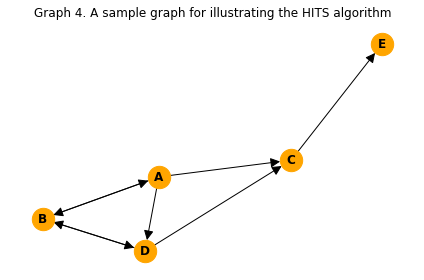

In [90]:
G4 = nx.DiGraph()
G4.add_nodes_from(["A","B","C","D","E"])
G4.add_edges_from([
    ("A","B"), ("A","C"), ("A","D"), 
    ("B","A"), ("B","D"),
    ("C","E"),    
    ("D","B"), ("D","C")
])

plt.figure()  
plt.title("Graph 4. A sample graph for illustrating the HITS algorithm")
nx.draw(G4, node_size=500, node_color='orange', with_labels=True, font_weight='bold', arrowsize=20)
plt.tight_layout()
plt.show()

The link matrix or adjacency matrix of $G4$ is given by:

In [95]:
nx.adjacency_matrix(G4).toarray()

array([[0, 1, 1, 1, 0],
       [1, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0]])

## Deriving the HITS update rule

Recall in PageRank that the score of a page is distributed to its successors. In the case of HITS, the score passed to the successors. In order to prevent values from growing without bounds, the values are normally scaled so that the largest value of a component is 1. 

Given constants $\lambda$ and $\mu$ to represent the scaling factor, we can describe the iteration step for updating $\textbf{h}$ and $\textbf{a}$ as follows:
* $\textbf{h'}  = \lambda L \textbf{a} $
* $\textbf{a'}  = \mu L^T \textbf{h} $

Since the hubbiness of a page is proportional to the authority of its *successors*, and the authority of a page is proportional to the hubbiness of its *predecessors*, we can actually compute for hubbiness independently, giving us a form that allows us to compute the two values independently.
* $\textbf{h'}  = \lambda \mu L L^{T} \textbf{a} $
* $\textbf{a'}  = \lambda \mu L^T
L \textbf{h} $

However, since $L L^{T}$ and $L^{T} L$ are not sparse, it is actually better to compute  $\textbf{h}$ and $\textbf{a}$ recursively. We outline method in the next subsection.

## HITS Algorithm

We can summarize the HITS algorithm as follows:

Initialize $\textbf{h}$ and $\textbf{a}$ to a vectors of 1's (of size $n$)

Iterate:

1. Compute $\textbf{a}  = \mu L^T \textbf{h} $
2. Scale $\textbf{a}$ so that the largest component is 1 (i.e., divide each element by the maximum value.)
3. Compute $\textbf{h}  = \mu L^T \textbf{a} $
4. Scale $\textbf{h}$ so that the largest component is 1 

 Until changes to $\textbf{h}$ and $\textbf{a}$ are sufficiently small.

We implement the hits algorithm below.

In [96]:
def hits(L, tol=10**-6, max_iter=100):
    """Compute the PageRank of a given Transition Matrix

    Parameters
    ----------
    L : numpy array
        Link Matrix: Array of shape (n, n), where n is the number of nodes in the network
    tol : float
        Tolerance: Iteration stops if the distance between previous and updated PageRank vectors 
        goes below this value
    max_iter : integer
        Maximum number of iterations
    Returns
    -------
    h, a : tuple of numpy array
        Vectors of size n containing the hub and authority values 
    """
    h = np.ones(L.shape[0])
    a = np.ones(L.shape[0])
    delta = 1/tol # initialize to a large number
    i = 0
    while delta > tol:
        i += 1
        
        # save old values
        prev_h = h
        prev_a = a

        # update a
        a = L.T.dot(h)    
        # scale a
        a = a/np.max(a)

        # update h
        h = L.dot(a)
        # scale h
        h = h/np.max(h)

        delta = np.mean([
                np.sum(np.abs(h-prev_h)), 
                np.sum(np.abs(a-prev_a))
                ])
        if i >= max_iter:
            break        
    return h, a

In [98]:
L = nx.adjacency_matrix(G4).toarray()
h, a = hits(L)
print(f'h: {h}')
print(f'a: {a}')

h: [1.00000000e+00 3.58257838e-01 1.02588408e-11 7.16515005e-01
 0.00000000e+00]
a: [2.08712567e-01 1.00000000e+00 1.00000000e+00 7.91288371e-01
 2.86353830e-11]


# Summary

# Exercises

1. As discussed above, Google introduced the innovation of judging the importance of a page by the terms used in the link, and not just hte links that appeared in the page. How does this defeat Term Spam?
2. Why not just count the number of inlinks to a page instead of doing PageRank?
3. Explain the meaning of the first term and second term in the RHS of the equation for PageRank with Taxation.
$
    \textbf{v}^{(t+1)}= \beta M\textbf{v}^{(t)} + (1-\beta)\textbf{e}/n
$
4.



# Reference

* Jure Leskovec, Anand Rajaraman, and Jeffrey D Ullman. Mining of massive datasets, chapter 5. Cambridge University Press, 3rd edition, 2019. http://www.mmds.org/. All figures, except Figure 2, were cropped from this book. Figure 2 was adapted from the presentation slides made available by the authors of the same book.